In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
import os
import glob

%matplotlib inline

## The Goal
The general goal of this EDA is to attempt to tag the trails with only comments from the user. Therefore, we will be cleaning the trail data to use only user entries that have a comment related to their experience on the trail. This comment will help to classify the condition that the trail is in for the future data entries by the user. 

The more cleaner way of doing this is to hand label all there entries and use that for classification. 

In [104]:
csvs = []
for i in glob.glob("../Data/*.csv", recursive=True):
    csvs.append(i)

csvs

['../Data/adams-canyon-trail.csv',
 '../Data/scout-falls-trail.csv',
 '../Data/dog-lake-via-big-water-trail.csv',
 '../Data/lake-catherine-via-brighton-lakes-trail.csv',
 '../Data/lake-desolation-mill-d-north-trail.csv',
 '../Data/centerville-canyon-via-deuel-creek-trail.csv',
 '../Data/desolation-trail-to-salt-lake-overlook.csv',
 '../Data/waterfall-canyon-trail.csv',
 '../Data/grandeur-peak-east-trail-from-church-fork.csv',
 '../Data/horsetail-falls-trail.csv',
 '../Data/donut-falls-trail.csv',
 '../Data/battle-creek-falls.csv',
 '../Data/mt-timpanogos-timpooneke-trail.csv',
 '../Data/willow-heights-trail.csv',
 '../Data/bells-canyon-trail-to-lower-falls.csv',
 '../Data/fifth-water-hot-springs-trail.csv',
 '../Data/ferguson-canyon-trail-to-upper-meadow.csv',
 '../Data/cecret-lake-trail.csv',
 '../Data/lake-mary-trail.csv',
 '../Data/heughs-canyon-trail.csv']

In [165]:
df = []
for i in csvs:
    print(i)
    ds = pd.read_csv(i)
    df.append(ds)

df = pd.concat((pd.read_csv(i) for i in csvs),axis=0, ignore_index=True, sort=False)
df
    

../Data/adams-canyon-trail.csv
../Data/scout-falls-trail.csv
../Data/dog-lake-via-big-water-trail.csv
../Data/lake-catherine-via-brighton-lakes-trail.csv
../Data/lake-desolation-mill-d-north-trail.csv
../Data/centerville-canyon-via-deuel-creek-trail.csv
../Data/desolation-trail-to-salt-lake-overlook.csv
../Data/waterfall-canyon-trail.csv
../Data/grandeur-peak-east-trail-from-church-fork.csv
../Data/horsetail-falls-trail.csv
../Data/donut-falls-trail.csv
../Data/battle-creek-falls.csv
../Data/mt-timpanogos-timpooneke-trail.csv
../Data/willow-heights-trail.csv
../Data/bells-canyon-trail-to-lower-falls.csv
../Data/fifth-water-hot-springs-trail.csv
../Data/ferguson-canyon-trail-to-upper-meadow.csv
../Data/cecret-lake-trail.csv
../Data/lake-mary-trail.csv
../Data/heughs-canyon-trail.csv


,Unnamed: 0,Date,Tags,Comments,Unnamed: 4
0,0,2019-09-07,['hiking'],"Love Adams , love the waterfall, initial switc...",NaN
1,1,2019-09-06,['hiking'],Hiked this today with our 4 and 6 year old. A ...,NaN
2,2,2019-09-04,"['trail running', 'closed']",Currently closed because of the Snoqualmie fire.,NaN
3,3,2019-09-03,"['hiking', 'bugs', 'scramble']","I did this trail on August 15th, 2019. It was ...",NaN
4,4,2019-09-02,['hiking'],The Sandy switch backs kinda kicks your butt i...,NaN
...,...,...,...,...,...
16603,492,2016-04-09,[''],NaN,NaN
16604,493,2016-04-04,['hiking'],NaN,NaN
16605,494,2016-04-03,[''],NaN,NaN
16606,495,2016-03-18,['hiking'],NaN,NaN


In [166]:
# Drop the index column
df = df.drop(['Unnamed: 0','Unnamed: 4'], axis=1)
df.head()

,Date,Tags,Comments
0,2019-09-07,['hiking'],"Love Adams , love the waterfall, initial switc..."
1,2019-09-06,['hiking'],Hiked this today with our 4 and 6 year old. A ...
2,2019-09-04,"['trail running', 'closed']",Currently closed because of the Snoqualmie fire.
3,2019-09-03,"['hiking', 'bugs', 'scramble']","I did this trail on August 15th, 2019. It was ..."
4,2019-09-02,['hiking'],The Sandy switch backs kinda kicks your butt i...


There is also bunch of rows with no comment or tags. We need to remove them and clean-up the data. 

In [167]:
# Lets remove rows with no comments
df = df[pd.notnull(df['Comments'])]
df.shape

(7252, 3)

#### Here is another way to drop rows with NAN, the only difference is that this one removes everything
df = df.dropna()

In [168]:
cf = df
cf

,Date,Tags,Comments
0,2019-09-07,['hiking'],"Love Adams , love the waterfall, initial switc..."
1,2019-09-06,['hiking'],Hiked this today with our 4 and 6 year old. A ...
2,2019-09-04,"['trail running', 'closed']",Currently closed because of the Snoqualmie fire.
3,2019-09-03,"['hiking', 'bugs', 'scramble']","I did this trail on August 15th, 2019. It was ..."
4,2019-09-02,['hiking'],The Sandy switch backs kinda kicks your butt i...
...,...,...,...
16290,2015-05-04,['hiking'],"Trailhead access does feel dodgy, as you're wa..."
16291,2015-04-30,[''],Amazing variety of landscape! A couple of spri...
16292,2015-04-19,['hiking'],I like this new hike I found! Decent variety- ...
16293,2014-09-18,['hiking'],"If you work nearby and have an hour to spare, ..."


In [169]:
# remove the brackets and quatations
def cleanit(df, text_field):
    df[text_field] = df[text_field].str.strip("'[]")
    df[text_field] = df[text_field].str.replace("'","")
    return df

In [170]:
cleanit(cf, 'Tags')

,Date,Tags,Comments
0,2019-09-07,hiking,"Love Adams , love the waterfall, initial switc..."
1,2019-09-06,hiking,Hiked this today with our 4 and 6 year old. A ...
2,2019-09-04,"trail running, closed",Currently closed because of the Snoqualmie fire.
3,2019-09-03,"hiking, bugs, scramble","I did this trail on August 15th, 2019. It was ..."
4,2019-09-02,hiking,The Sandy switch backs kinda kicks your butt i...
...,...,...,...
16290,2015-05-04,hiking,"Trailhead access does feel dodgy, as you're wa..."
16291,2015-04-30,,Amazing variety of landscape! A couple of spri...
16292,2015-04-19,hiking,I like this new hike I found! Decent variety- ...
16293,2014-09-18,hiking,"If you work nearby and have an hour to spare, ..."


Now let's expand out classification column into a "multi labeled" series of classes.

In [171]:
Tag_cols = cf['Tags'].str.split(",", expand=True)

Now we can combine the data-frame and the tags.

In [176]:
cdf = pd.concat([df,Tag_cols],axis=1, sort=False)
cdf.head()

,Date,Tags,Comments,0,1,2,3,4,5,6
0,2019-09-07,hiking,"Love Adams , love the waterfall, initial switc...",hiking,None,None,None,None,None,None
1,2019-09-06,hiking,Hiked this today with our 4 and 6 year old. A ...,hiking,None,None,None,None,None,None
2,2019-09-04,"trail running, closed",Currently closed because of the Snoqualmie fire.,trail running,closed,None,None,None,None,None
3,2019-09-03,"hiking, bugs, scramble","I did this trail on August 15th, 2019. It was ...",hiking,bugs,scramble,None,None,None,None
4,2019-09-02,hiking,The Sandy switch backs kinda kicks your butt i...,hiking,None,None,None,None,None,None


In [177]:
cdf = cdf.rename(columns={0:"class0",1:"class1",2:"class2",3:"class3",4:"class4",5:"class5",6:"class6"})
cdf.head()

,Date,Tags,Comments,class0,class1,class2,class3,class4,class5,class6
0,2019-09-07,hiking,"Love Adams , love the waterfall, initial switc...",hiking,None,None,None,None,None,None
1,2019-09-06,hiking,Hiked this today with our 4 and 6 year old. A ...,hiking,None,None,None,None,None,None
2,2019-09-04,"trail running, closed",Currently closed because of the Snoqualmie fire.,trail running,closed,None,None,None,None,None
3,2019-09-03,"hiking, bugs, scramble","I did this trail on August 15th, 2019. It was ...",hiking,bugs,scramble,None,None,None,None
4,2019-09-02,hiking,The Sandy switch backs kinda kicks your butt i...,hiking,None,None,None,None,None,None


So now we have a dataset with multi-label for classification and the comment column. We will be cleaning up the label column in order to prepare it for classification. 

In [178]:
df = cdf

Let's remove the columns that are not going to be use. 

In [179]:
df = df.drop(['Tags'],axis=1)
df.head()

,Date,Comments,class0,class1,class2,class3,class4,class5,class6
0,2019-09-07,"Love Adams , love the waterfall, initial switc...",hiking,None,None,None,None,None,None
1,2019-09-06,Hiked this today with our 4 and 6 year old. A ...,hiking,None,None,None,None,None,None
2,2019-09-04,Currently closed because of the Snoqualmie fire.,trail running,closed,None,None,None,None,None
3,2019-09-03,"I did this trail on August 15th, 2019. It was ...",hiking,bugs,scramble,None,None,None,None
4,2019-09-02,The Sandy switch backs kinda kicks your butt i...,hiking,None,None,None,None,None,None


Now let's add some the Jday column as a predictor. 

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7252 entries, 0 to 16294
Data columns (total 9 columns):
Date        7252 non-null object
Comments    7252 non-null object
class0      7252 non-null object
class1      503 non-null object
class2      232 non-null object
class3      75 non-null object
class4      25 non-null object
class5      5 non-null object
class6      1 non-null object
dtypes: object(9)
memory usage: 566.6+ KB


In [181]:
df.Date = pd.to_datetime(df['Date'], format="%Y-%m-%d")

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7252 entries, 0 to 16294
Data columns (total 9 columns):
Date        7252 non-null datetime64[ns]
Comments    7252 non-null object
class0      7252 non-null object
class1      503 non-null object
class2      232 non-null object
class3      75 non-null object
class4      25 non-null object
class5      5 non-null object
class6      1 non-null object
dtypes: datetime64[ns](1), object(8)
memory usage: 566.6+ KB


In [183]:
df['DOY'] = df['Date'].dt.dayofyear

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7252 entries, 0 to 16294
Data columns (total 10 columns):
Date        7252 non-null datetime64[ns]
Comments    7252 non-null object
class0      7252 non-null object
class1      503 non-null object
class2      232 non-null object
class3      75 non-null object
class4      25 non-null object
class5      5 non-null object
class6      1 non-null object
DOY         7252 non-null int64
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 623.2+ KB


In [185]:
class_name = []
sums = []
for i in df.columns:
    print(i, df[i].isna().sum())
    class_name.append(i)
    sums.append(df[i].isna().sum())

Date 0
Comments 0
class0 0
class1 6749
class2 7020
class3 7177
class4 7227
class5 7247
class6 7251
DOY 0


So there is close to 1200 rows that dont have any comments

In [186]:
import matplotlib.pyplot as plt
%matplotlib inline

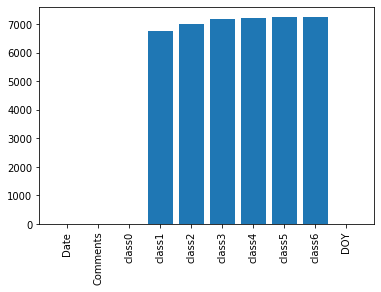

In [188]:
plt.bar(class_name,sums)
plt.xticks(rotation=90)
plt.show()

In [190]:
df

,Date,Comments,class0,class1,class2,class3,class4,class5,class6,DOY
0,2019-09-07,"Love Adams , love the waterfall, initial switc...",hiking,None,None,None,None,None,None,250
1,2019-09-06,Hiked this today with our 4 and 6 year old. A ...,hiking,None,None,None,None,None,None,249
2,2019-09-04,Currently closed because of the Snoqualmie fire.,trail running,closed,None,None,None,None,None,247
3,2019-09-03,"I did this trail on August 15th, 2019. It was ...",hiking,bugs,scramble,None,None,None,None,246
4,2019-09-02,The Sandy switch backs kinda kicks your butt i...,hiking,None,None,None,None,None,None,245
...,...,...,...,...,...,...,...,...,...,...
16290,2015-05-04,"Trailhead access does feel dodgy, as you're wa...",hiking,None,None,None,None,None,None,124
16291,2015-04-30,Amazing variety of landscape! A couple of spri...,,None,None,None,None,None,None,120
16292,2015-04-19,I like this new hike I found! Decent variety- ...,hiking,None,None,None,None,None,None,109
16293,2014-09-18,"If you work nearby and have an hour to spare, ...",hiking,None,None,None,None,None,None,261


In [193]:
tags = Counter(df['class0'])
tags

Counter({'hiking': 4637,
         'trail running': 66,
         '': 2326,
         'rocky': 5,
         'bugs': 2,
         'muddy': 9,
         'walking': 38,
         'camping': 24,
         'bird watching': 14,
         'rock climbing': 4,
         'mountain biking': 7,
         'backpacking': 54,
         'cross country skiing': 12,
         'road biking': 1,
         'snowshoeing': 35,
         'fishing': 2,
         'skiing': 1,
         'off road driving': 2,
         'horseback riding': 2,
         'nature trips': 7,
         'scenic driving': 2,
         'snow': 1,
         'paddle sports': 1})

As can be seen there is still some 2300 records that have no labels in class0. Lets see what they are!

In [195]:
df = df[df['class0']!='']

In [220]:
df.head()

,Date,Comments,class0,class1,class2,class3,class4,class5,class6,DOY
0,2019-09-07,"Love Adams , love the waterfall, initial switc...",hiking,None,None,None,None,None,None,250
1,2019-09-06,Hiked this today with our 4 and 6 year old. A ...,hiking,None,None,None,None,None,None,249
2,2019-09-04,Currently closed because of the Snoqualmie fire.,trail running,closed,None,None,None,None,None,247
3,2019-09-03,"I did this trail on August 15th, 2019. It was ...",hiking,bugs,scramble,None,None,None,None,246
4,2019-09-02,The Sandy switch backs kinda kicks your butt i...,hiking,None,None,None,None,None,None,245


In [222]:
df['class1'].fillna(value=pd.np.nan, inplace=True)

/home/fyousef/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [246]:
labels= ['class0', 'class1', 'class2', 'class3', 'class4', 'class5', 'class6']

In [252]:
def plott(tag):
    plt.bar([str(i[0]) for i in tag],[i[1] for i in tag])
    plt.xticks(rotation=90)
    plt.show()

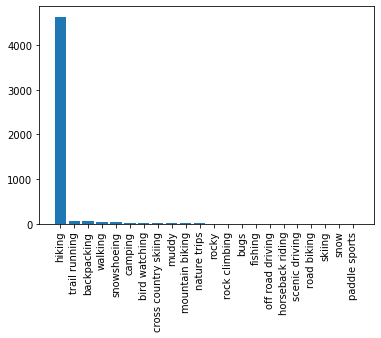

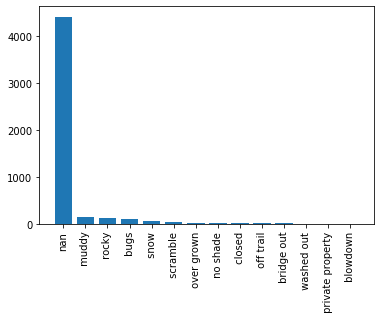

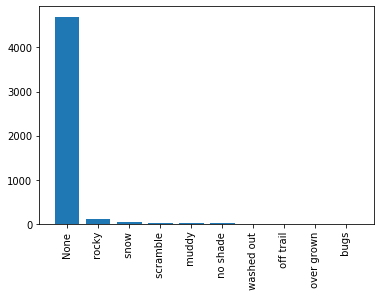

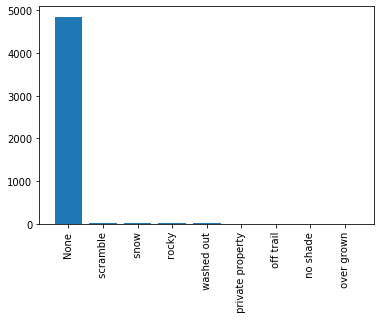

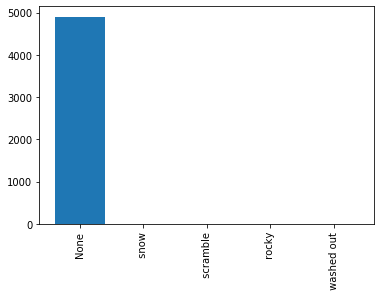

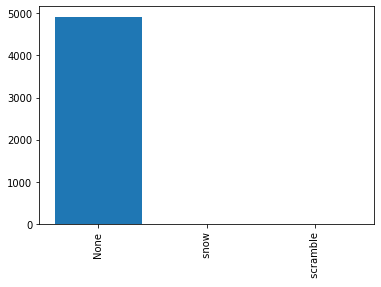

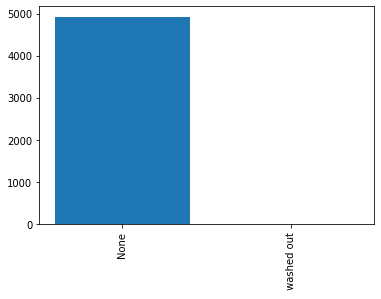

In [254]:
for label in labels:
    tag = Counter(df[label].tolist())
    tag = tag.most_common()
    plott(tag)
    
    

This code will remove the first category to have a better look at the other labels.

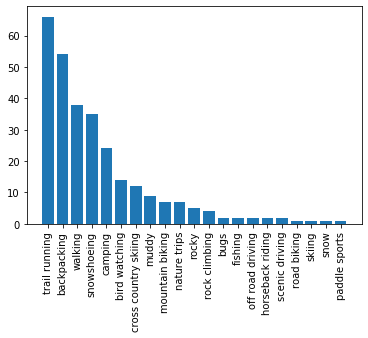

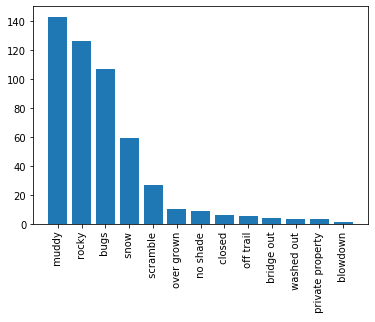

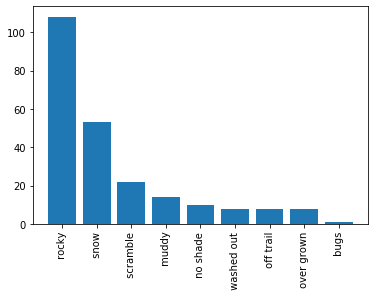

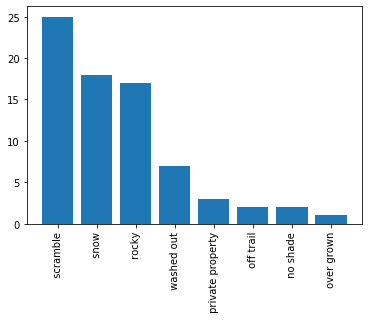

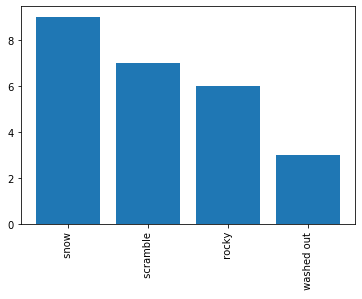

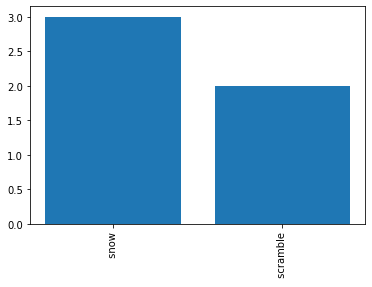

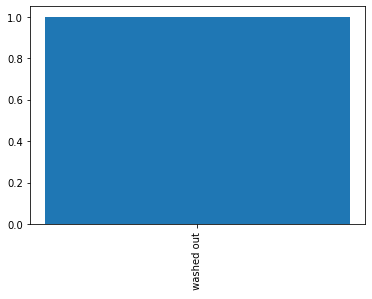

In [255]:
for label in labels:
    tag = Counter(df[label].tolist())
    tag = tag.most_common()
    tag = tag[1:]
    plott(tag)

Now we can proceed to check/clean the data before classification.

In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4926 entries, 0 to 16294
Data columns (total 10 columns):
Date        4926 non-null datetime64[ns]
Comments    4926 non-null object
class0      4926 non-null object
class1      503 non-null object
class2      232 non-null object
class3      75 non-null object
class4      25 non-null object
class5      5 non-null object
class6      1 non-null object
DOY         4926 non-null int64
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 423.3+ KB


We will remove the date column it is not important anymore. 

In [262]:
df = df.drop(['Date', 'DOY'], axis=1)
df.head()

,Comments,class0,class1,class2,class3,class4,class5,class6
0,"Love Adams , love the waterfall, initial switc...",hiking,NaN,None,None,None,None,None
1,Hiked this today with our 4 and 6 year old. A ...,hiking,NaN,None,None,None,None,None
2,Currently closed because of the Snoqualmie fire.,trail running,closed,None,None,None,None,None
3,"I did this trail on August 15th, 2019. It was ...",hiking,bugs,scramble,None,None,None,None
4,The Sandy switch backs kinda kicks your butt i...,hiking,NaN,None,None,None,None,None


In [263]:
df[labels].describe()

,class0,class1,class2,class3,class4,class5,class6
count,4926,503,232,75,25,5,1
unique,22,13,9,8,4,2,1
top,hiking,muddy,rocky,scramble,snow,snow,washed out
freq,4637,143,108,25,9,3,1
